# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

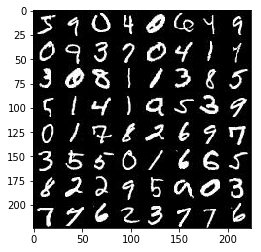

In [4]:
show_n_images = 75

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

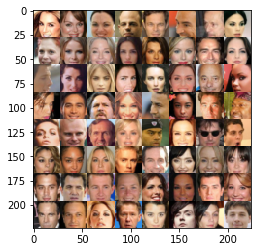

In [5]:
show_n_images = 75

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real_ph = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    inputs_z_ph = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate_ph = tf.placeholder(tf.float32, name="lr")
    return inputs_real_ph, inputs_z_ph, learning_rate_ph


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # for leaky ReLUs
    alpha=0.2
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x1 or 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # for leaky ReLUs
    alpha=0.2

    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        # used stride=1 here to have one extra layer
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    total_samples, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    steps = 0
    print_every = 10
    show_every = 100
    show_images_count = 75
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # According to the description, the values of the datasets are in the range of -0.5 to 0.5.
                # rescale the images to be between -1 and 1
                batch_images = batch_images * 2


                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, show_images_count, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2721... Generator Loss: 2.1317
Epoch 1/2... Discriminator Loss: 0.6354... Generator Loss: 3.7256
Epoch 1/2... Discriminator Loss: 1.3285... Generator Loss: 1.0440
Epoch 1/2... Discriminator Loss: 1.3601... Generator Loss: 2.3285
Epoch 1/2... Discriminator Loss: 0.8940... Generator Loss: 1.0966
Epoch 1/2... Discriminator Loss: 1.3052... Generator Loss: 0.7422
Epoch 1/2... Discriminator Loss: 0.8832... Generator Loss: 1.2274
Epoch 1/2... Discriminator Loss: 1.0471... Generator Loss: 1.6658
Epoch 1/2... Discriminator Loss: 1.1075... Generator Loss: 1.6346
Epoch 1/2... Discriminator Loss: 0.9838... Generator Loss: 1.5827


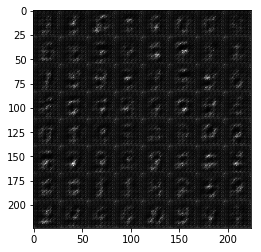

Epoch 1/2... Discriminator Loss: 1.4144... Generator Loss: 2.1147
Epoch 1/2... Discriminator Loss: 1.4149... Generator Loss: 0.4860
Epoch 1/2... Discriminator Loss: 1.5592... Generator Loss: 0.4781
Epoch 1/2... Discriminator Loss: 1.2747... Generator Loss: 0.8215
Epoch 1/2... Discriminator Loss: 1.1267... Generator Loss: 0.6850
Epoch 1/2... Discriminator Loss: 0.9317... Generator Loss: 1.0431
Epoch 1/2... Discriminator Loss: 1.2021... Generator Loss: 0.5312
Epoch 1/2... Discriminator Loss: 1.4122... Generator Loss: 0.4622
Epoch 1/2... Discriminator Loss: 1.2011... Generator Loss: 1.3510
Epoch 1/2... Discriminator Loss: 1.1189... Generator Loss: 1.1182


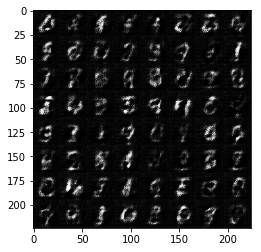

Epoch 1/2... Discriminator Loss: 1.0739... Generator Loss: 1.0788
Epoch 1/2... Discriminator Loss: 1.1143... Generator Loss: 0.8344
Epoch 1/2... Discriminator Loss: 1.3726... Generator Loss: 0.4662
Epoch 1/2... Discriminator Loss: 1.0677... Generator Loss: 0.8380
Epoch 1/2... Discriminator Loss: 1.0651... Generator Loss: 1.9212
Epoch 1/2... Discriminator Loss: 0.7912... Generator Loss: 1.1060
Epoch 1/2... Discriminator Loss: 0.7934... Generator Loss: 0.9892
Epoch 1/2... Discriminator Loss: 1.2222... Generator Loss: 0.4692
Epoch 1/2... Discriminator Loss: 0.7156... Generator Loss: 1.5245
Epoch 1/2... Discriminator Loss: 1.0472... Generator Loss: 0.6503


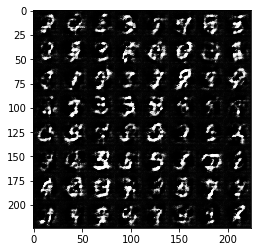

Epoch 1/2... Discriminator Loss: 1.0414... Generator Loss: 0.6353
Epoch 1/2... Discriminator Loss: 0.7780... Generator Loss: 1.0094
Epoch 1/2... Discriminator Loss: 0.8758... Generator Loss: 1.0166
Epoch 1/2... Discriminator Loss: 1.4204... Generator Loss: 2.4474
Epoch 1/2... Discriminator Loss: 0.9593... Generator Loss: 0.6986
Epoch 1/2... Discriminator Loss: 1.0057... Generator Loss: 2.1902
Epoch 1/2... Discriminator Loss: 1.0325... Generator Loss: 2.4593
Epoch 1/2... Discriminator Loss: 0.9085... Generator Loss: 0.8213
Epoch 1/2... Discriminator Loss: 0.9418... Generator Loss: 0.8005
Epoch 1/2... Discriminator Loss: 0.8893... Generator Loss: 0.8783


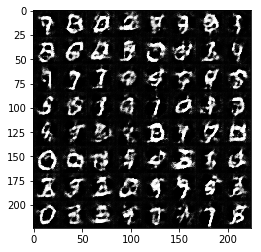

Epoch 1/2... Discriminator Loss: 0.9148... Generator Loss: 1.2886
Epoch 1/2... Discriminator Loss: 0.8615... Generator Loss: 0.9059
Epoch 1/2... Discriminator Loss: 0.9455... Generator Loss: 2.0583
Epoch 1/2... Discriminator Loss: 0.7288... Generator Loss: 1.1466
Epoch 1/2... Discriminator Loss: 1.0102... Generator Loss: 2.2451
Epoch 1/2... Discriminator Loss: 0.9087... Generator Loss: 1.1736
Epoch 2/2... Discriminator Loss: 1.1224... Generator Loss: 1.8818
Epoch 2/2... Discriminator Loss: 1.0433... Generator Loss: 1.4264
Epoch 2/2... Discriminator Loss: 1.1620... Generator Loss: 0.5764
Epoch 2/2... Discriminator Loss: 1.2200... Generator Loss: 0.4888


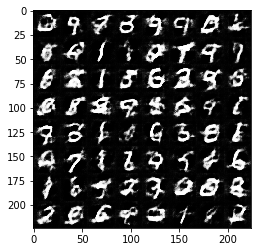

Epoch 2/2... Discriminator Loss: 0.7423... Generator Loss: 1.0445
Epoch 2/2... Discriminator Loss: 1.0219... Generator Loss: 1.0947
Epoch 2/2... Discriminator Loss: 1.1881... Generator Loss: 0.5173
Epoch 2/2... Discriminator Loss: 0.9394... Generator Loss: 0.7434
Epoch 2/2... Discriminator Loss: 0.9482... Generator Loss: 0.9521
Epoch 2/2... Discriminator Loss: 0.9524... Generator Loss: 1.6947
Epoch 2/2... Discriminator Loss: 0.9910... Generator Loss: 0.6774
Epoch 2/2... Discriminator Loss: 0.9714... Generator Loss: 1.4521
Epoch 2/2... Discriminator Loss: 1.0620... Generator Loss: 1.0334
Epoch 2/2... Discriminator Loss: 1.1224... Generator Loss: 0.5265


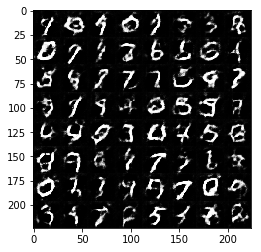

Epoch 2/2... Discriminator Loss: 0.9147... Generator Loss: 0.9091
Epoch 2/2... Discriminator Loss: 0.9968... Generator Loss: 1.1437
Epoch 2/2... Discriminator Loss: 1.0177... Generator Loss: 1.2622
Epoch 2/2... Discriminator Loss: 0.9520... Generator Loss: 0.7395
Epoch 2/2... Discriminator Loss: 0.9212... Generator Loss: 1.4563
Epoch 2/2... Discriminator Loss: 1.0483... Generator Loss: 0.8282
Epoch 2/2... Discriminator Loss: 1.0998... Generator Loss: 2.0899
Epoch 2/2... Discriminator Loss: 1.1922... Generator Loss: 0.4801
Epoch 2/2... Discriminator Loss: 0.8186... Generator Loss: 1.4922
Epoch 2/2... Discriminator Loss: 1.0386... Generator Loss: 0.7313


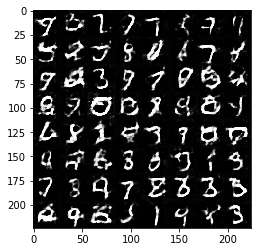

Epoch 2/2... Discriminator Loss: 1.1271... Generator Loss: 0.5494
Epoch 2/2... Discriminator Loss: 0.8687... Generator Loss: 1.0509
Epoch 2/2... Discriminator Loss: 0.9969... Generator Loss: 0.7301
Epoch 2/2... Discriminator Loss: 1.0670... Generator Loss: 1.7568
Epoch 2/2... Discriminator Loss: 0.8770... Generator Loss: 0.9537
Epoch 2/2... Discriminator Loss: 0.7991... Generator Loss: 1.1035
Epoch 2/2... Discriminator Loss: 1.0362... Generator Loss: 0.6485
Epoch 2/2... Discriminator Loss: 1.0031... Generator Loss: 0.6964
Epoch 2/2... Discriminator Loss: 0.8839... Generator Loss: 0.9071
Epoch 2/2... Discriminator Loss: 1.0133... Generator Loss: 1.2434


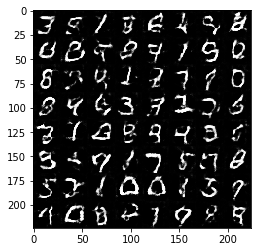

Epoch 2/2... Discriminator Loss: 0.8035... Generator Loss: 0.9264
Epoch 2/2... Discriminator Loss: 0.8711... Generator Loss: 1.2829
Epoch 2/2... Discriminator Loss: 0.7789... Generator Loss: 1.0585
Epoch 2/2... Discriminator Loss: 0.7954... Generator Loss: 1.2005
Epoch 2/2... Discriminator Loss: 0.8537... Generator Loss: 0.8827
Epoch 2/2... Discriminator Loss: 1.2656... Generator Loss: 0.4343
Epoch 2/2... Discriminator Loss: 1.2914... Generator Loss: 1.6258
Epoch 2/2... Discriminator Loss: 0.8423... Generator Loss: 1.1118
Epoch 2/2... Discriminator Loss: 0.8091... Generator Loss: 1.5404
Epoch 2/2... Discriminator Loss: 1.4339... Generator Loss: 2.1734


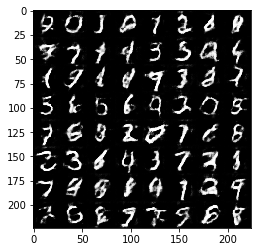

Epoch 2/2... Discriminator Loss: 1.0211... Generator Loss: 0.7032
Epoch 2/2... Discriminator Loss: 0.8630... Generator Loss: 1.2734
Epoch 2/2... Discriminator Loss: 0.7377... Generator Loss: 1.2138


In [20]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.4569... Generator Loss: 0.2560
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.5510
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.5012
Epoch 1/1... Discriminator Loss: 0.8366... Generator Loss: 2.9718
Epoch 1/1... Discriminator Loss: 1.7579... Generator Loss: 0.3598
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 1.2896
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 2.7321
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 1.5192


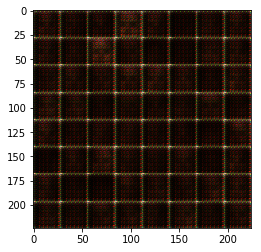

Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 1.3795
Epoch 1/1... Discriminator Loss: 1.6896... Generator Loss: 0.3894
Epoch 1/1... Discriminator Loss: 1.7889... Generator Loss: 0.4293
Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 1.2921
Epoch 1/1... Discriminator Loss: 1.6805... Generator Loss: 1.7586
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 1.5177
Epoch 1/1... Discriminator Loss: 1.6087... Generator Loss: 0.3029
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 1.3490
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.9644


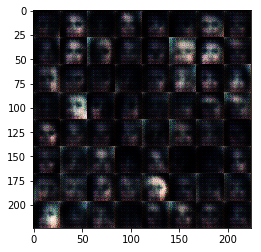

Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 1.0432
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 1.1371
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 1.5758
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 1.2265
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 1.1191
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.4247
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.6336


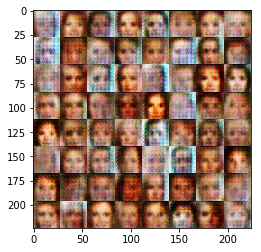

Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 1.2217
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.4364
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 1.0105
Epoch 1/1... Discriminator Loss: 1.5390... Generator Loss: 0.4125
Epoch 1/1... Discriminator Loss: 1.7219... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.6769


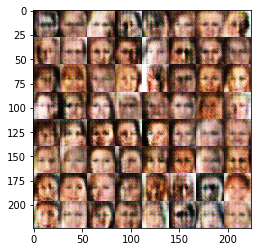

Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 1.0412
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.5499
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.9413


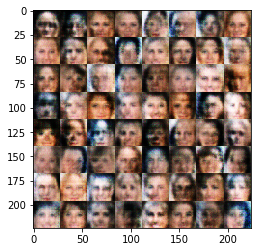

Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.7559


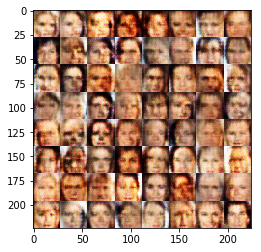

Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.5847
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.7936


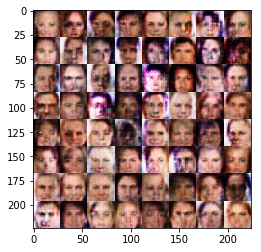

Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.9696
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.6355
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.5423
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 1.0465
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.6266


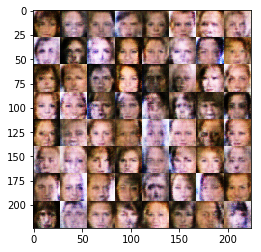

Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.5229
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.8984
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.7803


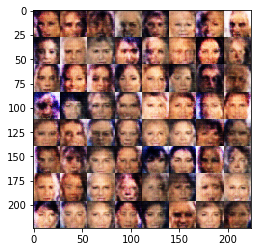

Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.4836
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.8177


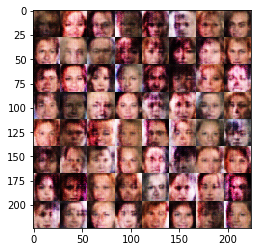

Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.9861
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.5443
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.5619


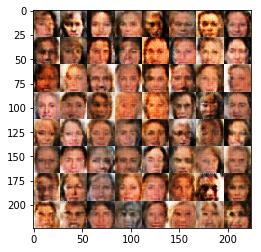

Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.5089
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.7794


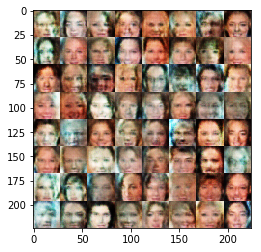

Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.4736
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.5380
Epoch 1/1... Discriminator Loss: 1.7979... Generator Loss: 0.3239
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.8005


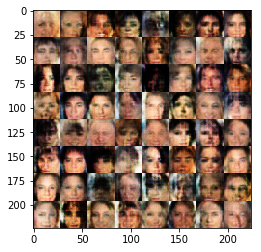

Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 1.0852
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.9471
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.4978
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.5230
Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 1.0948
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.8524


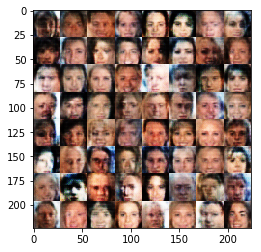

Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.5038
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.6251... Generator Loss: 1.8473
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.5140
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.5040


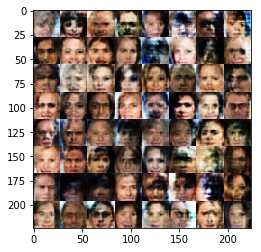

Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 1.1022
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.5594
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.9928
Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.9071
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 1.0309


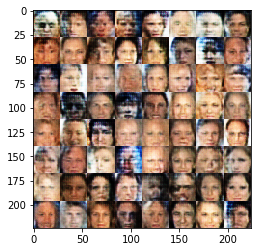

Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.4793
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 1.1054... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.9519
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.7746


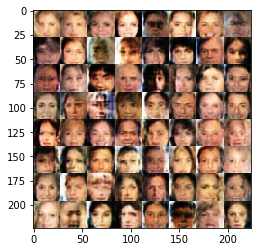

Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 1.0314
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 1.0973
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 1.2474
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.6136... Generator Loss: 0.3474
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.5853


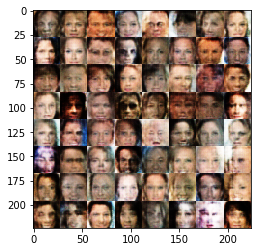

Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 1.0420
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 1.0908
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.5380
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.5668
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.5388
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.8429


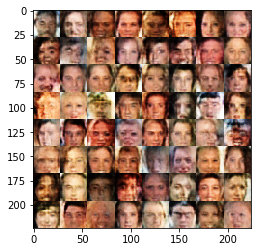

Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.4959
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.6849


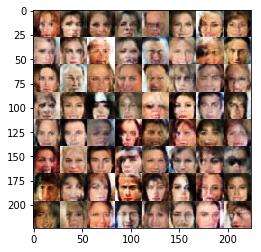

Epoch 1/1... Discriminator Loss: 1.5768... Generator Loss: 0.4132
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.5121
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.5650
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.5788
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.5308


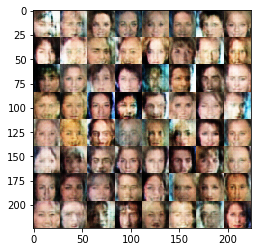

Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 0.9265
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 0.8594
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.5246
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.4684
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 0.9100


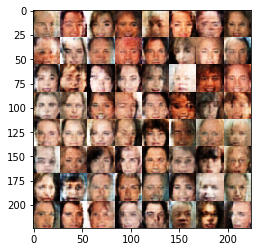

Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.5536
Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 0.4334
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 1.1013
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.4771
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.8869
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 1.2459


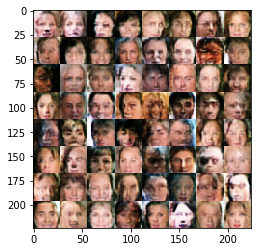

Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.6355
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 0.9731
Epoch 1/1... Discriminator Loss: 1.5524... Generator Loss: 0.4201
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 1.3432
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.4486


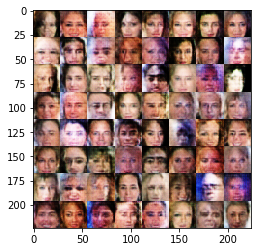

Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.4061


KeyboardInterrupt: 

In [21]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.45


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.